In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
from pylab import rcParams
from scipy import stats

from scipy.stats import f_oneway
from scipy.stats import ttest_ind
import statsmodels.api as sm
from statsmodels.formula.api import ols

import pingouin as pg

pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

In [3]:
# Plots
%matplotlib inline
warnings.filterwarnings("ignore")
rcParams['figure.figsize'] = 20,10
rcParams['font.size'] = 30
sns.set()
np.random.seed(8)

## Import processed data

In [29]:
# Selected recipes
s1 = pd.read_csv("./Pro_1/selectedrecipes.csv")
s2 = pd.read_csv("./Pro_2/selectedrecipes.csv")
s3 = pd.read_csv("./Pro_3/selectedrecipes.csv")

# Create groups based on demographic questions
demo1 = pd.read_csv("./Pro_1/demographics.csv")
demo2 = pd.read_csv("./Pro_2/demographics.csv")
demo3 = pd.read_csv("./Pro_3/demographics.csv")
md = pd.concat([demo1, demo2, demo3])

# Recipes
recipes = pd.read_csv("recipes_correct_fsa.csv")

# Add all data to one DF
ms = pd.concat([s1, s2, s3])
# Balance data (remove where user_id only selected 2 recipes)
ms = ms[ms['user_id'].map(ms['user_id'].value_counts()) > 2]


In [30]:
# End survey
e1 = pd.read_csv("./Pro_1/endsurvey.csv")
e2 = pd.read_csv("./Pro_2/endsurvey.csv")
e3 = pd.read_csv("./Pro_3/endsurvey.csv")

# Clean label_q3 column
e1['label_q3'] = e1['label_q3'].str.strip('[]').astype(str)
e1['label_q3'] = e1['label_q3'].str.replace('"', '')
e1['label_q3'] = e1['label_q3'].astype(str)

e2['label_q3'] = e2['label_q3'].str.strip('[]').astype(str)
e2['label_q3'] = e2['label_q3'].str.replace('"', '')
e2['label_q3'] = e2['label_q3'].astype(str)

e3['label_q3'] = e3['label_q3'].str.strip('[]').astype(str)
e3['label_q3'] = e3['label_q3'].str.replace('"', '')
e3['label_q3'] = e3['label_q3'].astype(str)

In [6]:
# Calculate mean FSA score for each condition
s1_fsa = s1["fsa_score"].mean()
s2_fsa = s2["fsa_score"].mean()
s3_fsa = s3["fsa_score"].mean()
s1_fsa = s1['fsa_score'].to_numpy()
s2_fsa = s2['fsa_score'].to_numpy()
s3_fsa = s3['fsa_score'].to_numpy()

In [31]:
# Get FSA score for different within-subjects variable EXCLUDE VEGANS
no_veg_id = md['user_id'].loc[md['restrictions'] != "vegan"].values

s1_no_veg = s1[s1['user_id'].isin(no_veg_id)]
s2_no_veg = s2[s2['user_id'].isin(no_veg_id)]
s3_no_veg = s3[s3['user_id'].isin(no_veg_id)]

# Add all data to one DF
ms_no_veg = pd.concat([s1_no_veg, s2_no_veg, s3_no_veg])
df_no_veg = ms_no_veg[['user_id', 'fsa_score', 'variant', 'condition', 'who_score', 'nutri_score']]


In [42]:
# Number of vegans
len(md)-len(no_veg_id)

53

In [39]:
# Get FSA score for different within-subjects variable EXCLUDE ALLERGIES
no_allerg_id = md['user_id'].loc[md['restrictions'] != "allergies"].values

s1_no_allerg = s1[s1['user_id'].isin(no_allerg_id)]
s2_no_allerg = s2[s2['user_id'].isin(no_allerg_id)]
s3_no_allerg = s3[s3['user_id'].isin(no_allerg_id)]

# Add all data to one DF
ms_no_allerg = pd.concat([s1_no_allerg, s2_no_allerg, s3_no_allerg])
df_no_allerg = ms_no_allerg[['user_id', 'fsa_score', 'variant', 'condition', 'who_score', 'nutri_score']]


In [41]:
# Number of allergies
len(md) -len(no_allerg_id)

5

In [9]:
anova_df = ms[['user_id', 'fsa_score', 'variant', 'condition', 'who_score', 'nutri_score']]

# Create a new column with names for each label
def label_name (row):
    if row['condition'] == 1 :
        return 'Nutriscore'
    if row['condition'] == 2 :
        return 'MTL'
    if row['condition'] == 3 :
        return 'No-label'

def rank_name (row):
    if row['variant'] == 1 :
        return 'Popular'
    if row['variant'] == 2 :
        return 'Random'
    if row['variant'] == 3 :
        return 'Health'

def numeric_nutriscore (row):
    if row['nutri_score'] == 'A' :
        return 1
    if row['nutri_score'] == 'B' :
        return 2
    if row['nutri_score'] == 'C' :
        return 3
    if row['nutri_score'] == 'D' :
        return 4
    if row['nutri_score'] == 'E' :
        return 5

anova_df['Label'] = anova_df.apply(lambda row: label_name(row), axis=1)
anova_df['Rank'] = anova_df.apply(lambda row: rank_name(row), axis=1)
anova_df['num_nutriscore'] = anova_df.apply(lambda row: numeric_nutriscore(row), axis=1)
ms['Label'] = ms.apply(lambda row: label_name(row), axis=1)
ms['Rank'] = ms.apply(lambda row: rank_name(row), axis=1)
ms['num_nutriscore'] = ms.apply(lambda row: numeric_nutriscore(row), axis=1)

In [23]:
# Divide dataset by cooking experience (Low, Medium, High)
c1 = md['user_id'].loc[md['experience'] == "cverylow"].values
c2 = md['user_id'].loc[md['experience'] == "clow"].values
c3 = md['user_id'].loc[md['experience'] == "cmedium"].values
c4 = md['user_id'].loc[md['experience'] == "chigh"].values
c5 = md['user_id'].loc[md['experience'] == "cveryhigh"].values

low = np.concatenate((c1, c2))
medium = c3
high = np.concatenate((c4, c5))

low_cooking = ms[ms['user_id'].isin(low)]
medium_cooking = ms[ms['user_id'].isin(medium)]
high_cooking = ms[ms['user_id'].isin(high)]

low_cooking['cooking_experience']='Low'
medium_cooking['cooking_experience']='Medium'
high_cooking['cooking_experience']='High'

cooking = pd.concat([low_cooking, medium_cooking, high_cooking])

cooking.to_csv('cooking.csv', index = False)


In [19]:
len(low_cooking)+len(medium_cooking)+len(high_cooking)

2061

In [28]:
e1 = md['user_id'].loc[md['education'] == 1].values
e2 = md['user_id'].loc[md['education'] == 2].values
e3 = md['user_id'].loc[md['education'] == 3].values
e4 = md['user_id'].loc[md['education'] == 4].values
e5 = md['user_id'].loc[md['education'] == 5].values
# Prefer not say: e6 = md['user_id'].loc[md['education'] == 6].values

less_high = ms[ms['user_id'].isin(e1)] # 
high = ms[ms['user_id'].isin(e2)]
bachelor = ms[ms['user_id'].isin(e3)]
master = ms[ms['user_id'].isin(e4)]
doc = ms[ms['user_id'].isin(e5)]

low = np.concatenate((e1,e2))
medium = e3
high = np.concatenate((e4,e5))

low_edu = ms[ms['user_id'].isin(low)]
bach_edu = ms[ms['user_id'].isin(medium)]
high_edu = ms[ms['user_id'].isin(high)]


low_edu['education']='low_edu'
bach_edu['education']='bach_edu'
high_edu['education']='high_edu'

education = pd.concat([low_edu,bach_edu, high_edu])

education.to_csv('education.csv', index = False)


In [26]:
# Eating habits
h1 = md['user_id'].loc[md['eating_habits'] == "vunhealthy"].values
h2 = md['user_id'].loc[md['eating_habits'] == "unhealthy"].values
h3 = md['user_id'].loc[md['eating_habits'] == "neutral"].values
h4 = md['user_id'].loc[md['eating_habits'] == "healthy"].values
h5 = md['user_id'].loc[md['eating_habits'] == "vhealhty"].values

pr = ms[ms['user_id'].isin(h1)]
sa = ms[ms['user_id'].isin(h2)]
fr = ms[ms['user_id'].isin(h3)]
vg = ms[ms['user_id'].isin(h4)]
lwe = ms[ms['user_id'].isin(h5)]


unhealthy = np.concatenate((h1, h2))
neutral = h3
healthy = np.concatenate((h4,h5))

unhealthy = ms[ms['user_id'].isin(unhealthy)]
neutral = ms[ms['user_id'].isin(neutral)]
healthy = ms[ms['user_id'].isin(healthy)]


unhealthy['eating_habits']='Unhealthy'
neutral['eating_habits']='Neutral'
healthy['eating_habits']='Healthy'

health = pd.concat([unhealthy, neutral, healthy])

health.to_csv('health.csv', index = False)



In [27]:
# Dietary goals
"""
6. Do you have any dietary goals? *
 Eat more protein

 Eat less salt

 Eat more fruit

 Eat more vegetables

 Lose weight

 Gain weight

 No goals
 """
g1 = md['user_id'].loc[md['goal'] == "protein"].values
g2 = md['user_id'].loc[md['goal'] == "salt"].values
g3 = md['user_id'].loc[md['goal'] == "fruit"].values
g4 = md['user_id'].loc[md['goal'] == "vegetables"].values
g5 = md['user_id'].loc[md['goal'] == "lweight"].values
g6 = md['user_id'].loc[md['goal'] == "gweight"].values
g7 = md['user_id'].loc[md['goal'] == "none"].values

pr = ms[ms['user_id'].isin(g1)]
sa = ms[ms['user_id'].isin(g1)]
fr = ms[ms['user_id'].isin(g3)]
vg = ms[ms['user_id'].isin(g4)]
lwe = ms[ms['user_id'].isin(g5)]
gwe = ms[ms['user_id'].isin(g6)]
none = ms[ms['user_id'].isin(g7)]

more = np.concatenate((g1, g3,g4,g6)) 
no_goal = g7
reduce = np.concatenate((g2,g5))

more = ms[ms['user_id'].isin(more)]
no_goal = ms[ms['user_id'].isin(no_goal)]
reduce = ms[ms['user_id'].isin(reduce)]

more['goal']='More'
no_goal['goal']='No_goal'
reduce['goal']='Reduce'

goal = pd.concat([more, no_goal, reduce])

goal.to_csv('goal.csv', index = False)



In [473]:
def eta_squared(aov):
    aov['eta_sq'] = 'NaN'
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    return aov

def omega_squared(aov):
    mse = aov['sum_sq'][-1]/aov['df'][-1]
    aov['omega_sq'] = 'NaN'
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*mse))/(sum(aov['sum_sq'])+mse)
    return aov

# Describe the data 

In [27]:
# Get mean FSA score for different conditions
print("Nutriscore:", stats.describe(s1_fsa), "\n")
print("MTL:", stats.describe(s2_fsa), "\n")
print("No-label:", stats.describe(s3_fsa), "\n")

Nutriscore: DescribeResult(nobs=707, minmax=(4, 10), mean=6.463932107496464, variance=1.8949437234294049, skewness=0.37679249507326007, kurtosis=-0.5197643618416139) 

MTL: DescribeResult(nobs=717, minmax=(4, 10), mean=6.338912133891213, variance=1.8081625020453005, skewness=0.36373432715542725, kurtosis=-0.48916295304367496) 

No-label: DescribeResult(nobs=708, minmax=(4, 10), mean=6.6341807909604515, variance=1.9154919729261066, skewness=0.19642257255473458, kurtosis=-0.6794028336858853) 



In [442]:
mean_df = anova_df[['Label','fsa_score']]
print(mean_df.groupby('Label').mean().to_latex(index=False))

\begin{tabular}{r}
\toprule
 fsa\_score \\
  6.351931 \\
\midrule
  6.644928 \\
  6.453102 \\
\bottomrule
\end{tabular}



### Condtition 1: Nutriscore FSA for different variants (Popular, random, health)

In [79]:
anova_df.loc[anova_df['condition'] == 1].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,6.930000e+02,693.000000,693.000000,693.0,693.000000,693.000000,693.000000
mean,8.011309e+11,6.453102,2.000000,1.0,3.180375,3.226551,9.679654
std,4.552867e+11,1.367313,0.817086,0.0,1.617486,1.128603,2.308843
min,3.194292e+09,4.000000,1.000000,1.0,1.000000,1.000000,5.000000
25%,4.425301e+11,5.000000,1.000000,1.0,2.000000,3.000000,8.000000
50%,7.544220e+11,6.000000,2.000000,1.0,3.000000,3.000000,9.000000
75%,1.163002e+12,7.000000,3.000000,1.0,4.000000,4.000000,11.000000
max,1.608333e+12,10.000000,3.000000,1.0,7.000000,5.000000,15.000000


In [98]:
# Variant 1: Popular ranking
anova_df[(anova_df['condition'] == 1)&(anova_df['variant'] == 1)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.310000e+02,231.000000,231.0,231.0,231.000000,231.000000,231.000000
mean,8.011309e+11,6.389610,1.0,1.0,3.251082,3.142857,9.532468
std,4.559461e+11,1.384597,0.0,0.0,1.630467,1.111767,2.289396
min,3.194292e+09,4.000000,1.0,1.0,1.000000,1.000000,5.000000
25%,4.443676e+11,5.000000,1.0,1.0,2.000000,2.500000,8.000000
50%,7.544220e+11,6.000000,1.0,1.0,2.000000,3.000000,9.000000
75%,1.160981e+12,7.000000,1.0,1.0,4.000000,4.000000,11.000000
max,1.608333e+12,10.000000,1.0,1.0,7.000000,5.000000,15.000000


In [99]:
# Variant 2: Random ranking
anova_df[(anova_df['condition'] == 1)&(anova_df['variant'] == 2)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.310000e+02,231.000000,231.0,231.0,231.000000,231.000000,231.000000
mean,8.011309e+11,6.471861,2.0,1.0,3.043290,3.242424,9.714286
std,4.559461e+11,1.318047,0.0,0.0,1.568116,1.142888,2.246875
min,3.194292e+09,4.000000,2.0,1.0,1.000000,1.000000,5.000000
25%,4.443676e+11,5.500000,2.0,1.0,2.000000,3.000000,9.000000
50%,7.544220e+11,6.000000,2.0,1.0,2.000000,3.000000,9.000000
75%,1.160981e+12,7.500000,2.0,1.0,4.000000,4.000000,11.500000
max,1.608333e+12,10.000000,2.0,1.0,7.000000,5.000000,15.000000


In [100]:
# Variant 3: Health ranking
anova_df[(anova_df['condition'] == 1)&(anova_df['variant'] == 3)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.310000e+02,231.000000,231.0,231.0,231.000000,231.000000,231.000000
mean,8.011309e+11,6.497835,3.0,1.0,3.246753,3.294372,9.792208
std,4.559461e+11,1.401473,0.0,0.0,1.651001,1.130569,2.390221
min,3.194292e+09,4.000000,3.0,1.0,1.000000,1.000000,5.000000
25%,4.443676e+11,5.000000,3.0,1.0,2.000000,3.000000,8.000000
50%,7.544220e+11,6.000000,3.0,1.0,3.000000,3.000000,9.000000
75%,1.160981e+12,8.000000,3.0,1.0,4.000000,4.000000,12.000000
max,1.608333e+12,10.000000,3.0,1.0,7.000000,5.000000,15.000000


### Condition 2: MTL FSA for different variants (Popular, random, health)

In [80]:
anova_df.loc[anova_df['condition'] == 2].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,6.990000e+02,699.000000,699.000000,699.0,699.000000,699.000000,699.000000
mean,8.011176e+11,6.351931,2.000000,2.0,3.114449,3.394850,9.746781
std,4.571528e+11,1.346451,0.817081,0.0,1.515367,1.000731,2.196044
min,6.885896e+09,4.000000,1.000000,2.0,1.000000,1.000000,5.000000
25%,4.296362e+11,5.000000,1.000000,2.0,2.000000,3.000000,9.000000
50%,7.797267e+11,6.000000,2.000000,2.0,3.000000,3.000000,9.000000
75%,1.202506e+12,7.000000,3.000000,2.0,4.000000,4.000000,11.000000
max,1.613553e+12,10.000000,3.000000,2.0,7.000000,5.000000,15.000000


In [97]:
# Variant 1: Popular ranking
anova_df[(anova_df['condition'] == 2)&(anova_df['variant'] == 1)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.330000e+02,233.000000,233.0,233.0,233.000000,233.000000,233.000000
mean,8.011176e+11,6.317597,1.0,2.0,3.188841,3.326180,9.643777
std,4.578092e+11,1.273906,0.0,0.0,1.613108,1.040578,2.155020
min,6.885896e+09,4.000000,1.0,2.0,1.000000,1.000000,5.000000
25%,4.296362e+11,5.000000,1.0,2.0,2.000000,3.000000,9.000000
50%,7.797267e+11,6.000000,1.0,2.0,2.000000,3.000000,9.000000
75%,1.202506e+12,7.000000,1.0,2.0,4.000000,4.000000,11.000000
max,1.613553e+12,10.000000,1.0,2.0,7.000000,5.000000,15.000000


In [96]:
# Variant 2: Random ranking
anova_df[(anova_df['condition'] == 2)&(anova_df['variant'] == 2)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.330000e+02,233.000000,233.0,233.0,233.000000,233.000000,233.000000
mean,8.011176e+11,6.304721,2.0,2.0,3.051502,3.416309,9.721030
std,4.578092e+11,1.344473,0.0,0.0,1.431454,0.948270,2.142415
min,6.885896e+09,4.000000,2.0,2.0,1.000000,1.000000,5.000000
25%,4.296362e+11,5.000000,2.0,2.0,2.000000,3.000000,9.000000
50%,7.797267e+11,6.000000,2.0,2.0,3.000000,3.000000,9.000000
75%,1.202506e+12,7.000000,2.0,2.0,4.000000,4.000000,11.000000
max,1.613553e+12,10.000000,2.0,2.0,7.000000,5.000000,15.000000


In [95]:
# Variant 3: Health ranking
anova_df[(anova_df['condition'] == 2)&(anova_df['variant'] == 3)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.330000e+02,233.000000,233.0,233.0,233.000000,233.000000,233.000000
mean,8.011176e+11,6.433476,3.0,2.0,3.103004,3.442060,9.875536
std,4.578092e+11,1.419110,0.0,0.0,1.499322,1.011715,2.290715
min,6.885896e+09,4.000000,3.0,2.0,1.000000,1.000000,5.000000
25%,4.296362e+11,5.000000,3.0,2.0,2.000000,3.000000,9.000000
50%,7.797267e+11,6.000000,3.0,2.0,3.000000,3.000000,9.000000
75%,1.202506e+12,8.000000,3.0,2.0,4.000000,4.000000,12.000000
max,1.613553e+12,10.000000,3.0,2.0,7.000000,5.000000,15.000000


### Condition 3: No-label FSA for different variants (Popular, random, health)

In [82]:
anova_df.loc[anova_df['condition'] == 3].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,6.900000e+02,690.000000,690.000000,690.0,690.000000,690.000000,690.000000
mean,7.899519e+11,6.644928,2.000000,3.0,2.836232,3.572464,10.217391
std,4.802112e+11,1.377829,0.817089,0.0,1.277524,0.943142,2.153537
min,3.275450e+09,4.000000,1.000000,3.0,1.000000,1.000000,5.000000
25%,3.847030e+11,6.000000,1.000000,3.0,2.000000,3.000000,9.000000
50%,7.791701e+11,6.000000,2.000000,3.0,2.000000,4.000000,10.000000
75%,1.224616e+12,8.000000,3.000000,3.0,3.000000,4.000000,12.000000
max,1.614694e+12,10.000000,3.000000,3.0,7.000000,5.000000,15.000000


In [94]:
# Variant 1: Popular ranking
anova_df[(anova_df['condition'] == 3)&(anova_df['variant'] == 1)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.300000e+02,230.000000,230.0,230.0,230.000000,230.000000,230.000000
mean,7.899519e+11,6.630435,1.0,3.0,2.908696,3.473913,10.104348
std,4.809097e+11,1.419741,0.0,0.0,1.365646,1.022335,2.254056
min,3.275450e+09,4.000000,1.0,3.0,1.000000,1.000000,5.000000
25%,3.859921e+11,6.000000,1.0,3.0,2.000000,3.000000,9.000000
50%,7.791701e+11,6.000000,1.0,3.0,2.000000,4.000000,9.000000
75%,1.223061e+12,8.000000,1.0,3.0,3.000000,4.000000,12.000000
max,1.614694e+12,10.000000,1.0,3.0,7.000000,5.000000,15.000000


In [93]:
# Variant 2: Random ranking
anova_df[(anova_df['condition'] == 3)&(anova_df['variant'] == 2)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.300000e+02,230.00000,230.0,230.0,230.000000,230.000000,230.000000
mean,7.899519e+11,6.56087,2.0,3.0,2.800000,3.634783,10.195652
std,4.809097e+11,1.34886,0.0,0.0,1.201891,0.844509,2.049812
min,3.275450e+09,4.00000,2.0,3.0,1.000000,1.000000,5.000000
25%,3.859921e+11,6.00000,2.0,3.0,2.000000,3.000000,9.000000
50%,7.791701e+11,6.00000,2.0,3.0,2.000000,4.000000,9.000000
75%,1.223061e+12,8.00000,2.0,3.0,3.000000,4.000000,12.000000
max,1.614694e+12,10.00000,2.0,3.0,6.000000,5.000000,15.000000


In [92]:
# Variant 3: Health ranking
anova_df[(anova_df['condition'] == 3)&(anova_df['variant'] == 3)].describe()

,user_id,fsa_score,variant,condition,who_score,num_nutriscore,combined_score
count,2.300000e+02,230.000000,230.0,230.0,230.000000,230.000000,230.000000
mean,7.899519e+11,6.743478,3.0,3.0,2.800000,3.608696,10.352174
std,4.809097e+11,1.363698,0.0,0.0,1.262146,0.950253,2.153979
min,3.275450e+09,4.000000,3.0,3.0,1.000000,1.000000,6.000000
25%,3.859921e+11,6.000000,3.0,3.0,2.000000,3.000000,9.000000
50%,7.791701e+11,7.000000,3.0,3.0,2.000000,4.000000,10.000000
75%,1.223061e+12,8.000000,3.0,3.0,3.000000,4.000000,12.000000
max,1.614694e+12,10.000000,3.0,3.0,7.000000,5.000000,15.000000


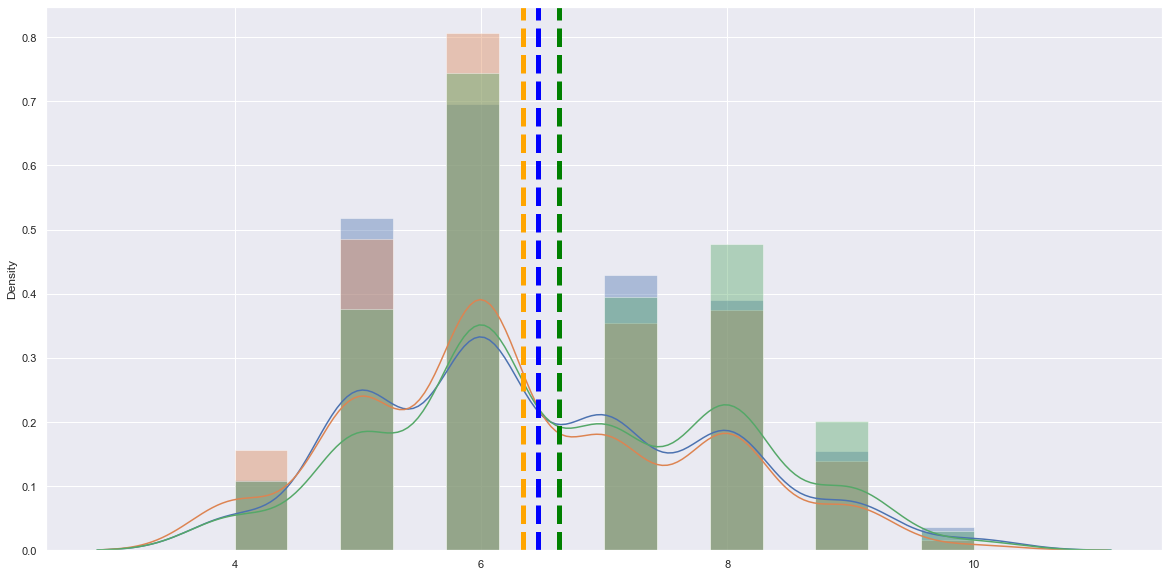

In [67]:
# Compare all conditions --> Plot FSA score distribution 
plt.figure()
ax1 = sns.distplot(s1_fsa)
ax2 = sns.distplot(s2_fsa)
ax3 = sns.distplot(s3_fsa)
plt.axvline(np.mean(s1_fsa), color='blue', linestyle='dashed', linewidth=5)    # Nutri-score
plt.axvline(np.mean(s2_fsa), color='orange', linestyle='dashed', linewidth=5)  # MTL
plt.axvline(np.mean(s3_fsa), color='green', linestyle='dashed', linewidth=5)   # No-label

* In the MTL condition participants choose the healthiest recipes overall 
* As expected participants in the No-label condition choose the least healthy recipes

In [434]:
anova_df['fsa_score']

0       6
1       6
2       6
3       6
4       6
       ..
702    10
703    10
704    10
705    10
707    10
Name: fsa_score, Length: 2082, dtype: int64

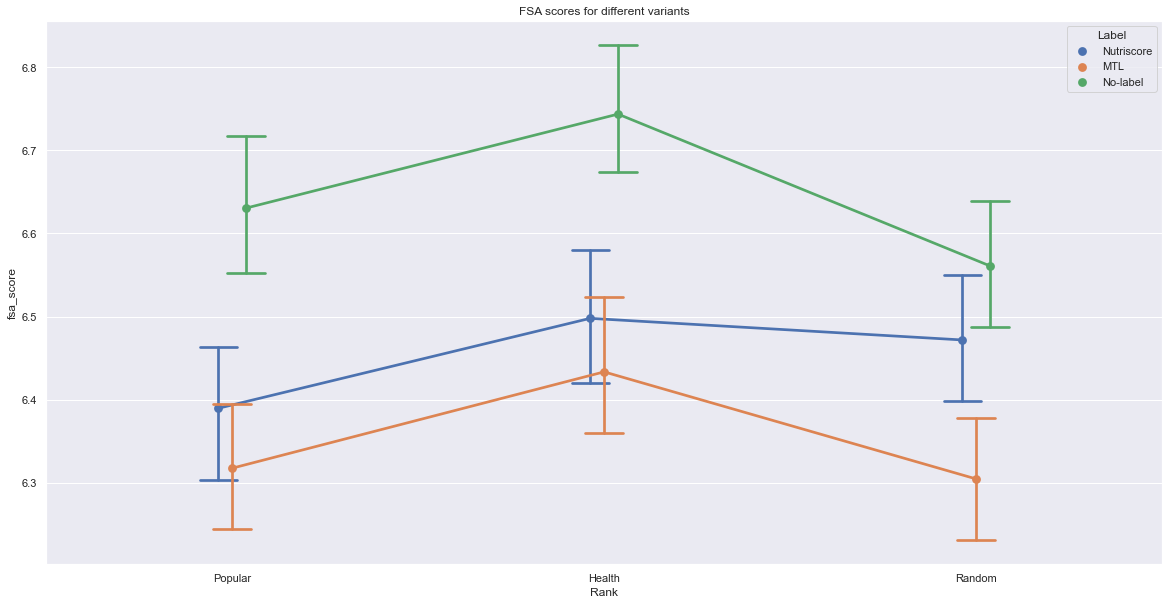

In [427]:
sns.pointplot(data=anova_df, x='Rank', y='fsa_score', hue='Label', dodge=True, capsize=.1, ci=61)
#plt.ylim(1, 7)
_ = plt.title('FSA scores for different variants')

In [430]:
# Calculate the standard error of 
# the mean of all the rows in dataframe
df_sem = df_anova[['Label','Rank', 'fsa_score']]
e = df_sem.sem(axis = 1, skipna = False)
x = df
plt.errorbar(x='Rank', y='fsa_score', e, linestyle='None', marker='^')

plt.show()

SyntaxError: positional argument follows keyword argument (<ipython-input-430-8353999d73f3>, line 6)

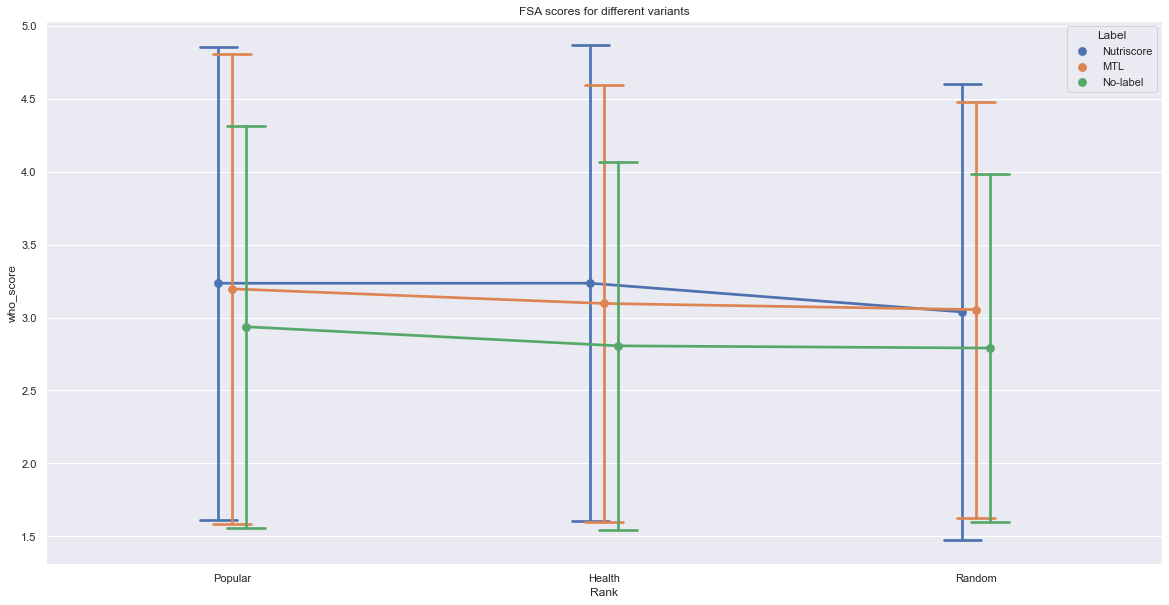

In [47]:
sns.pointplot(data=anova_df, x='Rank', y='who_score', hue='Label', dodge=True, capsize=.1, ci='sd')
_ = plt.title('WHO scores for different variants')

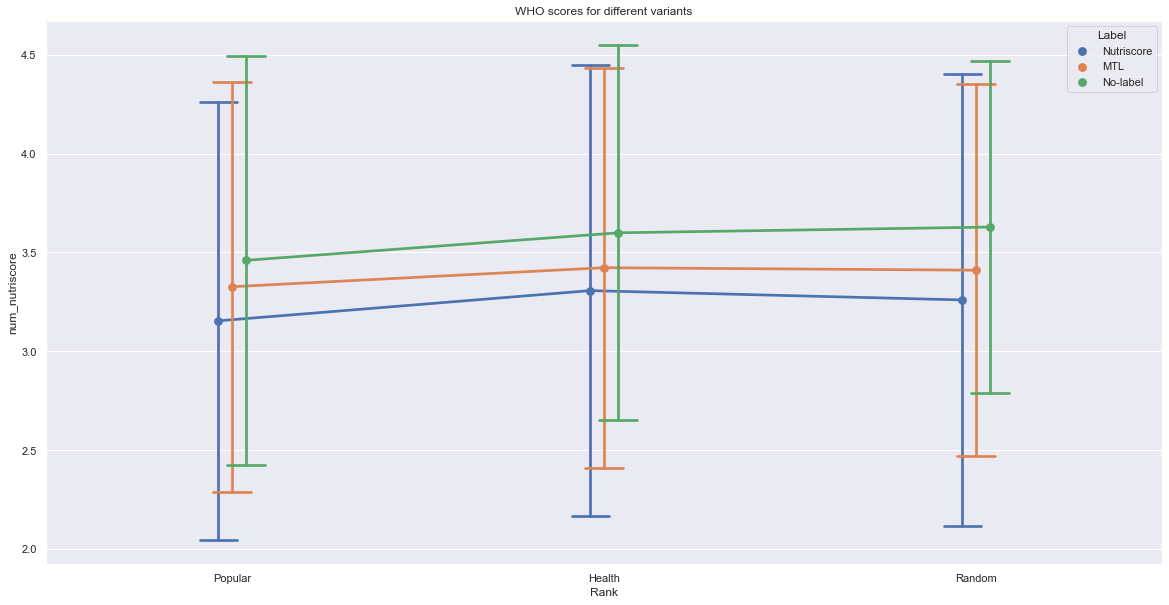

In [51]:
# NUMERIC NUTRISCORE: 1 = A, 5 = E
sns.pointplot(data=anova_df, x='Rank', y='num_nutriscore', hue='Label', dodge=True, capsize=.1, ci='sd')
_ = plt.title('Nutriscore scores for different variants')

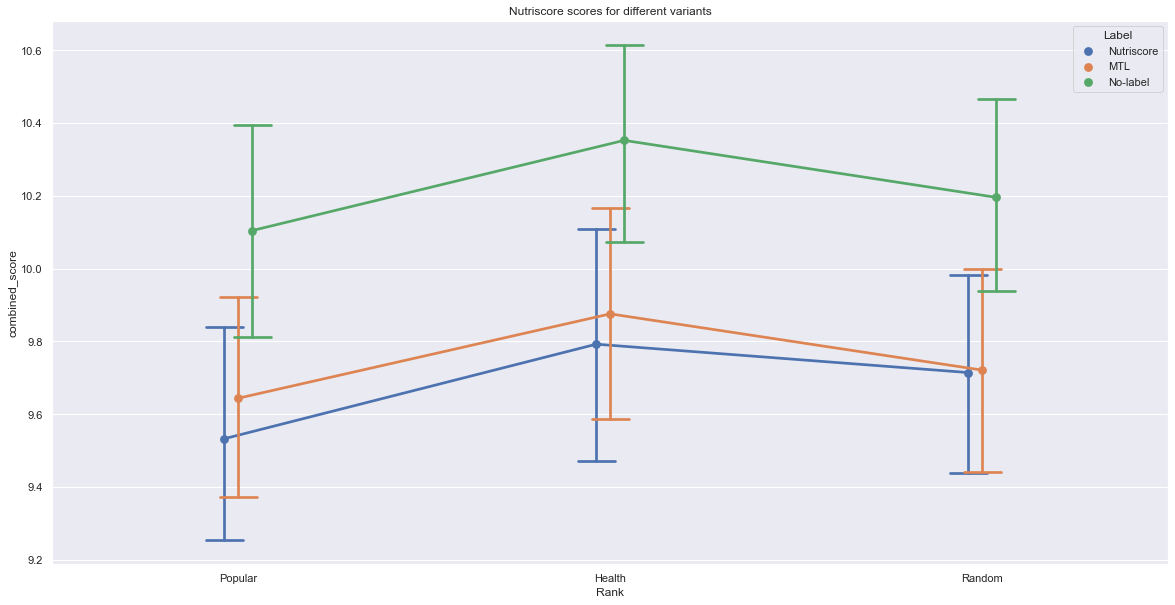

In [425]:
# Combine nutriscore and FSA score  NUTRISCORE: 1 = A, 5 = E
anova_df["combined_score"] = anova_df["num_nutriscore"] + anova_df["fsa_score"]

sns.pointplot(data=anova_df, x='Rank', y='combined_score', hue='Label', dodge=True, capsize=.1)
_ = plt.title('Nutriscore scores for different variants')

* 

# RQ1: To what extent can front-of-pack nutrition labels be used to nudge users towards healthier recipes online? 
Summary of findings: 
1. Labels work 
2. MTL is the superior label as compared to Nutriscore in Popular, Health and Random ranking scenarios. 
3. No significant difference when comparing Americans and Europeans with regards to different variants

## Two-way mixed ANOVA

In [323]:
aov = pg.mixed_anova(dv='fsa_score', between='Label', within='Rank', subject='user_id', data=anova_df)
aov

,Source,SS,DF1,DF2,MS,F,p-unc,np2,eps
0,Label,30.719553,2,691,15.359776,8.280076,0.000280,0.023405,NaN
1,Rank,5.844380,2,1382,2.922190,1.566750,0.209093,0.002262,0.998024
2,Interaction,1.880961,4,1382,0.470240,0.252122,0.908451,0.000729,NaN


* Since the p-values for label is less than .05, this means that label have a statistically significant effect on FSA score. The p-value for ranking is greater than .05, and ranking does not have a statistically significant effect on FSA score. 

* And since the p-value for the interaction effect (.908451) is not less than .05, this tells us that there is no significant interaction effect between label and ranking. 

In [422]:
len(anova_df['user_id'].unique())

694

In [450]:
aov = pg.mixed_anova(dv='who_score', between='Label', within='Rank', subject='user_id', data=anova_df)
aov

,Source,SS,DF1,DF2,MS,F,p-unc,p-GG-corr,np2,eps,sphericity,W-spher,p-spher
0,Label,46.143310,2,691,23.071655,11.604756,0.000011,NaN,0.032497,NaN,NaN,NaN,NaN
1,Rank,7.983670,2,1382,3.991835,1.749433,0.174257,0.174037,0.002525,0.988983,False,0.98886,0.020732
2,Interaction,2.584838,4,1382,0.646209,0.283203,0.888975,NaN,0.000819,NaN,NaN,NaN,NaN


# One-way ANOVA (compare conditions - between variable)
* The one-way ANOVA tests the null hypothesis that two or more groups have the same population mean. The test is applied to samples from two or more groups, possibly with differing sizes.
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.f_oneway.html


* We used one-way ANOVA to determine if there is a difference in FSA score between the different conditions. This can be interpreted as which condition made it easiest for the participant to make the healthiest choices. 
* FSA score = dependent variable

In [400]:
# 1. This is a between subject design, so the first step is to test for equality of variances
pg.homoscedasticity(data=anova_df, dv='fsa_score', group='condition')

,W,pval,equal_var
levene,2.529177,0.07997,True


In [403]:
# 2. If the groups have equal variances, we can use a regular one-way ANOVA
pg.anova(data=anova_df, dv='fsa_score', between='variant')

,Source,ddof1,ddof2,F,p-unc,np2
0,variant,2,2079,1.560941,0.210184,0.001499


In [402]:
### Remove vegans 
pg.anova(data=df_no_allerg, dv='fsa_score', between='condition
         ')

,Source,ddof1,ddof2,F,p-unc,np2
0,variant,2,2096,1.512229,0.220658,0.001441


In [364]:
### Remove people with alergies 
pg.anova(data=df_no_veg, dv='fsa_score', between='condition')

,Source,ddof1,ddof2,F,p-unc,np2
0,condition,2,1956,7.988418,0.000351,0.008102


In [53]:
# 3. If there is a main effect, we can proceed to post-hoc Tukey test
pg.pairwise_tukey(data=anova_df, dv='fsa_score', between='Label')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,MTL,No-label,6.338912,6.634181,-0.295269,0.072502,-4.072543,0.001000,-0.215659
1,MTL,Nutriscore,6.338912,6.463932,-0.125020,0.072528,-1.723746,0.196700,-0.091312
2,No-label,Nutriscore,6.634181,6.463932,0.170249,0.072757,2.339976,0.050685,0.124346


In [405]:
# 2. If the groups have equal variances, we can use a regular one-way ANOVA
pg.anova(data=anova_df, dv='fsa_score', between='variant')

,Source,ddof1,ddof2,F,p-unc,np2
0,variant,2,2079,1.560941,0.210184,0.001499


In [410]:
# 3. If there is a main effect, we can proceed to post-hoc Tukey test
pg.pairwise_tukey(data=anova_df, dv='who_score', between='Rank')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Health,Popular,3.050432,3.116715,-0.066282,0.079643,-0.832242,0.667530,-0.044653
1,Health,Random,3.050432,2.965418,0.085014,0.079643,1.067441,0.532977,0.057272
2,Popular,Random,3.116715,2.965418,0.151297,0.079643,1.899683,0.139036,0.101925


In [412]:
# 3. If there is a main effect, we can proceed to post-hoc Tukey test
pg.pairwise_tukey(data=anova_df, dv='fsa_score', between='Rank')

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,Health,Popular,6.557637,6.445245,0.112392,0.073451,1.530167,0.277407,0.082099
1,Health,Random,6.557637,6.445245,0.112392,0.073451,1.530167,0.277407,0.082099
2,Popular,Random,6.445245,6.445245,0.000000,0.073451,0.000000,0.900000,0.000000


In [ ]:
* 

# Repeated Measure ANOVA - For each condition
* An ANOVA with repeated measures is used to compare three or more group means where the participants are the same in each group. This usually occurs in two situations: (1) when participants are measured multiple times to see changes to an intervention; or (2) when participants are subjected to more than one condition/trial and the response to each of these conditions wants to be compared.
    * https://statistics.laerd.com/spss-tutorials/one-way-anova-repeated-measures-using-spss-statistics.php
    
* 

### Condition 1: Nutriscore RM ANOVA

In [301]:
# Get data
s1_df = s1[['fsa_score', 'variant', 'condition', 'user_id']]
s1_df['Label'] = s1_df.apply (lambda row: label_name(row), axis=1)
s1_df['Rank'] = s1_df.apply (lambda row: rank_name(row), axis=1)
# Balance data 
s1_df = s1_df[s1_df['user_id'].map(s1_df['user_id'].value_counts()) > 2]

# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s1_df, dv='fsa_score', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=s1_df, dv='fsa_score', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')


ANOVA SUMMARY

Source         SS    DF     MS        F    p-unc      np2      eps
--------  -------  ----  -----  -------  -------  -------  -------
Rank        1.475     2  0.737    0.387    0.679    0.002    0.986
Error     876.525   460  1.905  nan      nan      nan      nan


POST HOC TESTS

Contrast    A        B        Paired    Parametric         T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  ------  -------  ---------  -------  --------  ----------  ------  --------
Rank        Health   Popular  True      True           0.808  230.000  two-sided    0.420     0.791  fdr_bh       0.102     0.078
Rank        Health   Random   True      True           0.215  230.000  two-sided    0.830     0.830  fdr_bh       0.075     0.019
Rank        Popular  Random   True      True          -0.633  230.000  two-sided    0.527     0.791  fdr_bh       0.090    -0.061



### Condition 2: MTL RM ANOVA

In [300]:
# Get data
s2_df = s2[['fsa_score', 'variant', 'condition', 'user_id']]
s2_df['Label'] = s2_df.apply (lambda row: label_name(row), axis=1)
s2_df['Rank'] = s2_df.apply (lambda row: rank_name(row), axis=1)
# Balance data 
s2_df = s2_df[s2_df['user_id'].map(s2_df['user_id'].value_counts()) > 2]

# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s2_df, dv='fsa_score', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=s2_df, dv='fsa_score', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')


ANOVA SUMMARY

Source         SS    DF     MS        F    p-unc      np2      eps
--------  -------  ----  -----  -------  -------  -------  -------
Rank        2.343     2  1.172    0.642    0.527    0.003    0.998
Error     846.990   464  1.825  nan      nan      nan      nan


POST HOC TESTS

Contrast    A        B        Paired    Parametric        T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  -----  -------  ---------  -------  --------  ----------  ------  --------
Rank        Health   Popular  True      True          0.942  232.000  two-sided    0.347     0.521  fdr_bh       0.114     0.086
Rank        Health   Random   True      True          1.006  232.000  two-sided    0.316     0.521  fdr_bh       0.121     0.093
Rank        Popular  Random   True      True          0.103  232.000  two-sided    0.918     0.918  fdr_bh       0.074     0.010



### Condition 3: No-label RM ANOVA

In [299]:
# Get data
s3_df = s3[['fsa_score', 'variant', 'condition', 'user_id']]
s3_df['Label'] = s3_df.apply (lambda row: label_name(row), axis=1)
s3_df['Rank'] = s3_df.apply (lambda row: rank_name(row), axis=1)
# Balance data 
s3_df = s3_df[s3_df['user_id'].map(s3_df['user_id'].value_counts()) > 2]

# Do RM ANOVA for each condition 
pg.print_table(pg.rm_anova(data=s3_df, dv='fsa_score', within='Rank', subject='user_id', detailed=True))

# FDR-corrected post hocs with Hedges'g effect size
posthoc = pg.pairwise_ttests(data=s3_df, dv='fsa_score', within='Rank', subject='user_id',
                             parametric=True, padjust='fdr_bh', effsize='hedges')
pg.print_table(posthoc, floatfmt='.3f')


ANOVA SUMMARY

Source         SS    DF     MS        F    p-unc      np2      eps
--------  -------  ----  -----  -------  -------  -------  -------
Rank        3.907     2  1.954    1.048    0.352    0.005    0.989
Error     854.093   458  1.865  nan      nan      nan      nan


POST HOC TESTS

Contrast    A        B        Paired    Parametric        T      dof  Tail         p-unc    p-corr  p-adjust      BF10    hedges
----------  -------  -------  --------  ------------  -----  -------  ---------  -------  --------  ----------  ------  --------
Rank        Health   Popular  True      True          0.914  229.000  two-sided    0.361     0.542  fdr_bh       0.111     0.081
Rank        Health   Random   True      True          1.469  229.000  two-sided    0.143     0.430  fdr_bh       0.213     0.134
Rank        Popular  Random   True      True          0.520  229.000  two-sided    0.604     0.604  fdr_bh       0.084     0.050



# Pairwise T-test (compare different variants and conditions)
* https://pingouin-stats.org/generated/pingouin.pairwise_ttests.html

**Warning:**
Note that Pingouin gives slightly different T and p-values compared to JASP posthoc tests for 2-way factorial design, because Pingouin does not pool the standard error for each factor, but rather calculate each pairwise T-test completely independent of others.

In [448]:
# Balance data (remove where user_id only selected 2 recipes)
anova_df = anova_df[anova_df['user_id'].map(anova_df['user_id'].value_counts()) > 2]

pg.pairwise_ttests(data=anova_df, dv='fsa_score', between='Label', within='Rank', subject='user_id', padjust='bonf')

,Contrast,Rank,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Rank,-,Health,Popular,True,True,1.535340,693.000000,two-sided,0.125157,0.375470,bonf,0.138,0.081259
1,Rank,-,Health,Random,True,True,1.564760,693.000000,two-sided,0.118096,0.354287,bonf,0.144,0.082006
2,Rank,-,Popular,Random,True,True,0.000000,693.000000,two-sided,1.000000,1.000000,bonf,0.043,0.000000
3,Label,-,MTL,No-label,False,True,-3.982098,459.420859,two-sided,0.000079,0.000238,bonf,202.872,-0.369642
4,Label,-,MTL,Nutriscore,False,True,-1.406507,461.927492,two-sided,0.160246,0.480738,bonf,0.269,-0.130382
5,Label,-,No-label,Nutriscore,False,True,2.596931,458.025874,two-sided,0.009709,0.029126,bonf,2.67,0.241529
6,Rank * Label,Health,MTL,No-label,False,True,-2.396802,460.668368,two-sided,0.016936,0.152428,bonf,1.651,-0.222362
7,Rank * Label,Health,MTL,Nutriscore,False,True,-0.491506,461.993091,two-sided,0.623302,1.000000,bonf,0.116,-0.045559
8,Rank * Label,Health,No-label,Nutriscore,False,True,1.907233,458.757948,two-sided,0.057115,0.514032,bonf,0.6,0.177357
9,Rank * Label,Popular,MTL,No-label,False,True,-2.494441,454.361548,two-sided,0.012970,0.116728,bonf,2.076,-0.231643


## Conditions

### Nutriscore - MTL
* There is no statistically significantly difference in the dependent variable (FSA score) between Nutriscore and MTL(p.160246)	
* We expected the MTL label to perform better for people with higher food knowledge/trying to avoid certain nutrients
* We expected Nutriscore to perform better for people with lower food knowledge, because it makes it easier to determine the healthiness of a recipe without any prior knowledge of spcefic nutrients. 

###  Nutriscore - No label
* As expected there is a statistically significantly difference in the dependent variable FSA score between Nutriscore and No-label (.009709). 
* Nutriscore FSA mean=6.463932107496464
* No-label FSA mean=6.644928
* Overall participants chose healthier recipes in the Nutriscore condition.

###  MTL - No label
* As expected there is a statistically significantly difference (p 0.000079) in the dependent variable FSA score between MTL and No-label (.009709). 
* MTL FSA mean=6.351931
* No-label FSA mean=6.644928
* The difference is greater than between Nutriscore and No-label, indicating that MTL is the superior label. However in the Nutriscore condition recipes were ranked by Nutriscore and not FSA score, this might cause the comparison to not be 100% accurate. 

## Variants
* Compare the different rankings to see if there are any significant differences in ranking overall

### Overall compare different rankings (Popular, Random, Health)
* No significant difference in FSA score when looking only at the ranking. 
* Need to look at ranking in combination with labels -->

### Variant 1: Popular ranking compare between conditions

In [119]:
f_oneway(anova_df['fsa_score'][(anova_df['condition'] == 1)&(anova_df['variant'] == 1)], anova_df['fsa_score'][(anova_df['condition'] == 2)&(anova_df['variant'] == 1)], anova_df['fsa_score'][(anova_df['condition'] == 3)&(anova_df['variant'] == 1)])

F_onewayResult(statistic=3.349442899515842, pvalue=0.03567477156959914)

* There is a significant difference in FSA score between the different conditions when looking at the within-subjects variable "Popular ranking".
* Participants in the No-label condition choose less healthier recipes. 
* Participants in the MTL condition choose the healthiest recipes.
* This indicates that adding a health label might be beneficial since a lot of recipe sites rank recipes by popularity. 
* **Should also look at if the most popular recipes are healther than the less popular recipes**

#### Cond 1 - Cond 2 popular ranking FSA
* As expected there is no significant difference between MTL and Nutriscore with popular ranking.

#### Cond 1 - Cond 3 popular ranking FSA
* There is a difference between Nutriscore and No-label, but it is not statistically significant. 

#### Cond 2 - Cond 3 popular ranking FSA
* The biggest difference is between MTL and No-label, indicating that MTL is more effective than nutriscore in a popular ranking scenario. 

### Variant 2: Random ranking compare between conditions

In [117]:
# One-way ANOVA
f_oneway(anova_df['fsa_score'][(anova_df['condition'] == 1)&(anova_df['variant'] == 2)], anova_df['fsa_score'][(anova_df['condition'] == 2)&(anova_df['variant'] == 2)], anova_df['fsa_score'][(anova_df['condition'] == 3)&(anova_df['variant'] == 2)])

F_onewayResult(statistic=2.192147847819569, pvalue=0.11245268837243182)

* No significant difference between conditions in a random ranking scenario. 

#### Cond 1 - Cond 2 random ranking FSA
* No significant difference between Nutriscore and MTL.

#### Cond 1 - Cond 3 random ranking FSA
* No significant difference between Nutriscore and No-label.
* Would expect the Nutriscore label to make it easier for participants to select healthier recipes in a random ranking scenario. 
* However using nutriscore without ranking might lessen the effect of the nutriscore label. In a health ranking scenario the differences in healthiness becomes more apparent, and seeing the recipes become increasingly more unhealthy might make you more health aware..

#### Cond 2 - Cond 3 random ranking FSA
* There is a significant difference in FSA score between MTL and No-label in the random ranking scenario. 
* This might be because there is more information to be considered in the MTL label vs. the Nutriscore label?? Maybe there is an advantage in having more information to consider -- Colour + HIGH, MED, LOW + Amount of sugar/fat/satfat/salt? For some reason its easier to ignore the nutriscore in a random ranking scenario, while there is more information in the MTL label making it more natural to consider this information as well

### Variant 3: Health ranking compare between conditions

In [120]:
# One-way ANOVA
f_oneway(anova_df['fsa_score'][(anova_df['condition'] == 1)&(anova_df['variant'] == 3)], anova_df['fsa_score'][(anova_df['condition'] == 2)&(anova_df['variant'] == 3)], anova_df['fsa_score'][(anova_df['condition'] == 3)&(anova_df['variant'] == 3)])

F_onewayResult(statistic=3.175784649561375, pvalue=0.042371563748917866)

* Significant difference between conditions in a health ranking scenario.

#### Cond 1 - Cond 2 health ranking FSA
* No significant difference between MTL and nutriscore in a health ranking scenario

#### Cond 1 - Cond 3 health ranking FSA
* There is a significant difference between Nutriscore and No-label in the health ranking scenario

#### Cond 2 - Cond 3 health ranking FSA
* There is a significant difference between MTL and No-label in the health ranking scenario (p 0.016936) 
* The biggest difference is between MTL and No-label, indicating that MTL is more effective than nutriscore in a health ranking scenario. However MTL was ranked by FSA score, and Nutriscore condition was ranked by Nutriscore.
* Participants in the No-label condition choose the least healthy recipes in the health ranking condition! And the most healthy recipes in the random condition.

# Which label is the best? Nutriscore or MTL? 
* As we have already seen MTL is the superior lable in Health, random and popular ranking
* **We need to look closer at this because in the Health ranking scenario the recipes are ordered slightly different because MTL is ranked by FSA (4-12), while Nutriscore is ranked by the nutriscore (A-E)**

#### Problem: Nutriscore and MTL is calulated differently. How to account for this difference when comparing them? 
* Use WHO score

## Comparing MTL and Nutriscroe using WHO health score
* We need to have the same score to compare the two conditions to figure out which label works best (if any).
* A recipe or meal plan with a WHO score of 7 is interpreted as being very healthy whereas a score of 0 is seen as very unhealthy 
* FSA score: range from 4 (very healthy recipe) to 12 (very unhealthy recipe)

In [125]:
# Problem: The health ranking for Nutriscore and MTL is very different. Show top 10 recipes ordered by healthiness: 
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
  
display_side_by_side(rec.sort_values(by=['fsa_score']).head(10),rec.sort_values(by=['nutri_score']).head(10), titles=['MTL top 10','Nutriscore top 10'])

,recipe_name,fsa_score,nutri_score,who_score
57,Tomato and Garlic Pasta,4,C,5
23,Easy Chicken Rice Casserole,4,A,4
0,Amazing Brown Rice Salad,5,C,3
41,Pasta Chickpea Salad,5,A,7
35,Lemon Pepper Pasta,5,B,6
28,Fruit Salad in Seconds,5,D,3
49,"Scrumptious Chicken Vegetable style=""display:inline"" Stew",5,B,5
52,Spinach and Pasta Shells,5,B,6
14,Caribbean Sweet Potato Salad,5,C,3
21,Chickpea and Quinoa Salad with Lemon and Tahini,5,B,5


In [449]:
pg.pairwise_ttests(data=anova_df, dv='who_score', between='Label', within='Rank', subject='user_id',padjust='bonf' )

,Contrast,Rank,A,B,Paired,Parametric,T,dof,Tail,p-unc,p-corr,p-adjust,BF10,hedges
0,Rank,-,Health,Popular,True,True,-0.785678,693.000000,two-sided,0.432325,1.000000,bonf,0.058,-0.043634
1,Rank,-,Health,Random,True,True,1.104378,693.000000,two-sided,0.269813,0.809438,bonf,0.078,0.058555
2,Rank,-,Popular,Random,True,True,1.856235,693.000000,two-sided,0.063844,0.191533,bonf,0.236,0.102125
3,Label,-,MTL,No-label,False,True,3.824457,445.409460,two-sided,0.000150,0.000449,bonf,113.495,0.354444
4,Label,-,MTL,Nutriscore,False,True,-0.820958,461.715837,two-sided,0.412094,1.000000,bonf,0.143,-0.076106
5,Label,-,No-label,Nutriscore,False,True,-4.672751,439.427128,two-sided,0.000004,0.000012,bonf,3345.283,-0.434349
6,Rank * Label,Health,MTL,No-label,False,True,2.353609,449.811427,two-sided,0.019022,0.171194,bonf,1.496,0.218170
7,Rank * Label,Health,MTL,Nutriscore,False,True,-0.981549,456.993204,two-sided,0.326842,1.000000,bonf,0.164,-0.091025
8,Rank * Label,Health,No-label,Nutriscore,False,True,-3.264700,430.334578,two-sided,0.001183,0.010650,bonf,17.31,-0.303435
9,Rank * Label,Popular,MTL,No-label,False,True,2.017759,450.563055,two-sided,0.044209,0.397878,bonf,0.738,0.187045


1. Popular	MTL	Nutriscore = 0.679560
2. Random	MTL	Nutriscore = 0.953058
3. Health	MTL	Nutriscore = 0.326842
* Using WHO score to compare Nutriscore and MTL there are not any significant differences in WHO score between the different conditions. 

## Compare MTL - Nutriscore: Look at cooking experience 
* Some research sugests that MTL works best for high food knowledge and Nutriscore works best for lower food knowledge.
* Use cooking experience as a gauge for food knowledge: 

### Low cooking experience (Very low, Low)

In [474]:
pg.pairwise_ttests(data=low_cooking, dv='who_score', between='Label', within='Rank', subject='user_id')

,Contrast,Rank,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Rank,-,Health,Popular,True,True,-1.133395,143.000000,two-sided,0.258945,0.174,-0.133307
1,Rank,-,Health,Random,True,True,0.039178,143.000000,two-sided,0.968803,0.093,0.004648
2,Rank,-,Popular,Random,True,True,1.075967,143.000000,two-sided,0.283754,0.163,0.133674
3,Label,-,MTL,No-label,False,True,1.272278,79.029169,two-sided,0.207005,0.454,0.256636
4,Label,-,MTL,Nutriscore,False,True,-2.544880,97.376783,two-sided,0.012502,3.523,-0.490749
5,Label,-,No-label,Nutriscore,False,True,-3.567467,80.499997,two-sided,0.000611,46.198,-0.749068
6,Rank * Label,Health,MTL,No-label,False,True,0.323279,69.834864,two-sided,0.747450,0.234,0.068133
7,Rank * Label,Health,MTL,Nutriscore,False,True,-1.846404,88.732985,two-sided,0.068167,0.925,-0.361668
8,Rank * Label,Health,No-label,Nutriscore,False,True,-1.938836,80.401223,two-sided,0.056030,1.168,-0.407613
9,Rank * Label,Popular,MTL,No-label,False,True,2.603295,91.518975,two-sided,0.010772,4.136,0.461319


In [165]:
pg.pairwise_ttests(data=medium_cooking, dv='who_score', between='Label', within='Rank', subject='user_id')

,Contrast,Rank,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Rank,-,Health,Popular,True,True,0.558052,355.000000,two-sided,0.577160,0.069,0.044377
1,Rank,-,Health,Random,True,True,1.344561,355.000000,two-sided,0.179625,0.145,0.096869
2,Rank,-,Popular,Random,True,True,0.651514,355.000000,two-sided,0.515137,0.073,0.049489
3,Label,-,MTL,No-label,False,True,4.303010,219.419990,two-sided,0.000025,705.137,0.552182
4,Label,-,MTL,Nutriscore,False,True,0.404344,226.825073,two-sided,0.686341,0.156,0.053196
5,Label,-,No-label,Nutriscore,False,True,-3.874166,207.483444,two-sided,0.000143,145.777,-0.511173
6,Rank * Label,Health,MTL,No-label,False,True,2.901487,220.148033,two-sided,0.004091,7.167,0.372263
7,Rank * Label,Health,MTL,Nutriscore,False,True,0.306384,226.037204,two-sided,0.759594,0.151,0.040368
8,Rank * Label,Health,No-label,Nutriscore,False,True,-2.505867,203.600339,two-sided,0.012998,2.694,-0.331340
9,Rank * Label,Popular,MTL,No-label,False,True,1.233307,239.258999,two-sided,0.218671,0.287,0.157253


In [166]:
pg.pairwise_ttests(data=high_cooking, dv='who_score', between='Label', within='Rank', subject='user_id')

,Contrast,Rank,A,B,Paired,Parametric,T,dof,Tail,p-unc,BF10,hedges
0,Rank,-,Health,Popular,True,True,-0.967076,186.000000,two-sided,0.334762,0.129,-0.100462
1,Rank,-,Health,Random,True,True,0.424930,186.000000,two-sided,0.671379,0.089,0.044678
2,Rank,-,Popular,Random,True,True,1.489367,186.000000,two-sided,0.138084,0.242,0.154998
3,Label,-,MTL,No-label,False,True,0.238460,101.838873,two-sided,0.812004,0.204,0.044692
4,Label,-,MTL,Nutriscore,False,True,-0.247128,110.676131,two-sided,0.805267,0.202,-0.044832
5,Label,-,No-label,Nutriscore,False,True,-0.524457,133.564028,two-sided,0.600830,0.208,-0.088848
6,Rank * Label,Health,MTL,No-label,False,True,0.035349,102.891148,two-sided,0.971870,0.199,0.006609
7,Rank * Label,Health,MTL,Nutriscore,False,True,-1.067444,116.020693,two-sided,0.287988,0.329,-0.189708
8,Rank * Label,Health,No-label,Nutriscore,False,True,-1.195123,129.388297,two-sided,0.234225,0.351,-0.202003
9,Rank * Label,Popular,MTL,No-label,False,True,0.189286,102.086961,two-sided,0.850245,0.202,0.035456


### T-test -Low cooking experience
* Any difference between Nutriscore and MTL for participants with low cooking eperience? 

In [179]:
# Variant 1
ttest_ind(low_cooking['who_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 1)],low_cooking['who_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 1)])

Ttest_indResult(statistic=0.8586507188889744, pvalue=0.39243496022873636)

In [180]:
# Variant 2
ttest_ind(low_cooking['who_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 2)],low_cooking['who_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 2)])

Ttest_indResult(statistic=1.4649221237915206, pvalue=0.14584723607943795)

In [181]:
# Variant 3
ttest_ind(low_cooking['who_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 3)],low_cooking['who_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 3)])

Ttest_indResult(statistic=1.8985005967230093, pvalue=0.06029922715544506)

In [196]:
low_cooking['who_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 3)].mean()

3.3877551020408165

In [195]:
low_cooking['who_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 3)].mean()

2.8524590163934427

### T-test - High cooking experience
* Any difference between Nutriscore and MTL for participants with medium cooking eperience? 

In [182]:
# Variant 1
ttest_ind(medium_cooking['who_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 1)],medium_cooking['who_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 1)])

Ttest_indResult(statistic=0.6345481709292609, pvalue=0.5263621310065123)

In [183]:
# Variant 2
ttest_ind(medium_cooking['who_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 2)],medium_cooking['who_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 2)])

Ttest_indResult(statistic=-1.0318705707260354, pvalue=0.3032308766292216)

In [184]:
# Variant 3
ttest_ind(medium_cooking['who_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 3)],medium_cooking['who_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 3)])

Ttest_indResult(statistic=-0.30621819474333883, pvalue=0.7597191866494653)

### T-test - High cooking experience
* Any difference between Nutriscore and MTL for participants with medium cooking eperience? 

In [185]:
# Variant 1
ttest_ind(high_cooking['who_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 1)],high_cooking['who_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 1)])

Ttest_indResult(statistic=-0.5774554324372112, pvalue=0.5647320291393084)

In [186]:
# Variant 2
ttest_ind(high_cooking['who_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 2)],high_cooking['who_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 2)])

Ttest_indResult(statistic=-0.16074308177442156, pvalue=0.8725706248206697)

In [187]:
# Variant 3
ttest_ind(high_cooking['who_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 3)],high_cooking['who_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 3)])

Ttest_indResult(statistic=1.0311069640788015, pvalue=0.3045994453217519)

* No statistically significant differences when comparing variants between Nutriscore and MTL for participants with different cooking experience. 
* The largest difference was for participants with low cooking experience (pvalue=0.06029922715544506) in the Health ranking variant. According to the WHO score people in the MTL condition choose the healthiest recipes (mean WHO 2.852). In the Nutriscore condition (mean WHO 3.387) for participants in the healht ranking variant. However this difference was not statistically significant. When looking at FSA score for the same participants, Nutriscore performed best. 
* A bit hard to say which label is performing best beacuse it depends on which health score is used. 


## Does education level influence which label is the best?

## T-test -Low education
* Any difference between Nutriscore and MTL for participants with low education?

In [478]:
# Variant 1
ttest_ind(low_edu['who_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 1)],low_edu['who_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 1)])

Ttest_indResult(statistic=-0.144375169894708, pvalue=0.8853859161842936)

In [479]:
# Variant 2
ttest_ind(low_edu['who_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 2)],low_edu['who_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 2)])

Ttest_indResult(statistic=-1.2757207553556789, pvalue=0.2039032243498454)

In [480]:
# Variant 3
ttest_ind(low_edu['who_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 3)],low_edu['who_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 3)])

Ttest_indResult(statistic=1.3506333116805376, pvalue=0.17872006099493826)

## T-test - Bachelor education
* Any difference between Nutriscore and MTL for participants with medium (bachelor) education?

In [481]:
# Variant 1
ttest_ind(bach_edu['who_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 1)],bach_edu['who_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 1)])

Ttest_indResult(statistic=1.5674197458232526, pvalue=0.11860535019176006)

In [482]:
# Variant 2
ttest_ind(bach_edu['who_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 2)],bach_edu['who_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 2)])

Ttest_indResult(statistic=0.5559554946201346, pvalue=0.5788658202030796)

In [483]:
# Variant 3
ttest_ind(bach_edu['who_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 3)],bach_edu['who_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 3)])


Ttest_indResult(statistic=-0.13687972663686562, pvalue=0.8912642462934025)

## T-test - High education
* Any difference between Nutriscore and MTL for participants with high education?


In [484]:
# Variant 1
ttest_ind(high_edu['who_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 1)],high_edu['who_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 1)])


Ttest_indResult(statistic=-1.0097402360497045, pvalue=0.3152680929690913)

In [485]:
# Variant 2
ttest_ind(high_edu['who_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 2)],high_edu['who_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 2)])


Ttest_indResult(statistic=0.3200172830371746, pvalue=0.7496808736044447)

In [486]:
# Variant 3
ttest_ind(high_edu['who_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 3)],high_edu['who_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 3)])


Ttest_indResult(statistic=1.0138150560349755, pvalue=0.31332988306190684)

* No statistically significant differences when comparing variants between Nutriscore and MTL for participants with different  education level 

## Does eating habits influence which label is the best? 
* unhealthy
* neutral 
* healthy 

## T-test - Unhealthy eating habits
* Any difference between Nutriscore and MTL for participants with low education?

In [487]:
# Variant 1
ttest_ind(unhealthy['who_score'][(unhealthy['condition'] == 1)&(unhealthy['variant'] == 1)],unhealthy['who_score'][(unhealthy['condition'] == 2)&(unhealthy['variant'] == 1)])

Ttest_indResult(statistic=0.4544176303767627, pvalue=0.6508407307934942)

In [488]:
# Variant 2
ttest_ind(unhealthy['who_score'][(unhealthy['condition'] == 1)&(unhealthy['variant'] == 2)],unhealthy['who_score'][(unhealthy['condition'] == 2)&(unhealthy['variant'] == 2)])

Ttest_indResult(statistic=-0.5205904475688712, pvalue=0.6041856339865985)

In [489]:
# Variant 3
ttest_ind(unhealthy['who_score'][(unhealthy['condition'] == 1)&(unhealthy['variant'] == 3)],unhealthy['who_score'][(unhealthy['condition'] == 2)&(unhealthy['variant'] == 3)])

Ttest_indResult(statistic=1.676747560022176, pvalue=0.09775552479595306)

## T-test - Neutral eating habits
* Any difference between Nutriscore and MTL for participants with medium (bachelor) education?

In [490]:
# Variant 1
ttest_ind(neutral['who_score'][(neutral['condition'] == 1)&(neutral['variant'] == 1)],neutral['who_score'][(neutral['condition'] == 2)&(neutral['variant'] == 1)])

Ttest_indResult(statistic=-0.5437097658404807, pvalue=0.5873452462945339)

In [491]:
# Variant 2
ttest_ind(neutral['who_score'][(neutral['condition'] == 1)&(neutral['variant'] == 2)],neutral['who_score'][(neutral['condition'] == 2)&(neutral['variant'] == 2)])

Ttest_indResult(statistic=-0.7414815948025685, pvalue=0.4594126897699451)

In [492]:
# Variant 3
ttest_ind(neutral['who_score'][(neutral['condition'] == 1)&(neutral['variant'] == 3)],neutral['who_score'][(neutral['condition'] == 2)&(neutral['variant'] == 3)])


Ttest_indResult(statistic=1.5594642211332796, pvalue=0.1207246232058842)

## T-test - Healthy eating habits
* Any difference between Nutriscore and MTL for participants with high education?

In [493]:
# Variant 1
ttest_ind(healthy['who_score'][(healthy['condition'] == 1)&(healthy['variant'] == 1)],healthy['who_score'][(healthy['condition'] == 2)&(healthy['variant'] == 1)])

Ttest_indResult(statistic=1.01443502820392, pvalue=0.31156520250594855)

In [494]:
# Variant 2
ttest_ind(healthy['who_score'][(healthy['condition'] == 1)&(healthy['variant'] == 2)],healthy['who_score'][(healthy['condition'] == 2)&(healthy['variant'] == 2)])


Ttest_indResult(statistic=0.7871514155029009, pvalue=0.4320979163088313)

In [495]:
# Variant 3
ttest_ind(healthy['who_score'][(healthy['condition'] == 1)&(healthy['variant'] == 3)],healthy['who_score'][(healthy['condition'] == 2)&(healthy['variant'] == 3)])


Ttest_indResult(statistic=-0.847167100236789, pvalue=0.39788513184992136)

* No statistically significant differences when comparing variants between Nutriscore and MTL for participants with different  self reported eating habits (unhealthy, neutral, healthy)

## Does goals influence which label is the best? 
* 

## T-test - Unhealthy eating habits
* Any difference between Nutriscore and MTL for participants with low education?

In [496]:
# Variant 1
ttest_ind(unhealthy['who_score'][(unhealthy['condition'] == 1)&(unhealthy['variant'] == 1)],unhealthy['who_score'][(unhealthy['condition'] == 2)&(unhealthy['variant'] == 1)])

Ttest_indResult(statistic=0.4544176303767627, pvalue=0.6508407307934942)

In [497]:
# Variant 2
ttest_ind(unhealthy['who_score'][(unhealthy['condition'] == 1)&(unhealthy['variant'] == 2)],unhealthy['who_score'][(unhealthy['condition'] == 2)&(unhealthy['variant'] == 2)])

Ttest_indResult(statistic=-0.5205904475688712, pvalue=0.6041856339865985)

In [498]:
# Variant 3
ttest_ind(unhealthy['who_score'][(unhealthy['condition'] == 1)&(unhealthy['variant'] == 3)],unhealthy['who_score'][(unhealthy['condition'] == 2)&(unhealthy['variant'] == 3)])

Ttest_indResult(statistic=1.676747560022176, pvalue=0.09775552479595306)

## T-test - Neutral eating habits
* Any difference between Nutriscore and MTL for participants with medium (bachelor) education?

In [499]:
# Variant 1
ttest_ind(neutral['who_score'][(neutral['condition'] == 1)&(neutral['variant'] == 1)],neutral['who_score'][(neutral['condition'] == 2)&(neutral['variant'] == 1)])

Ttest_indResult(statistic=-0.5437097658404807, pvalue=0.5873452462945339)

In [500]:
# Variant 2
ttest_ind(neutral['who_score'][(neutral['condition'] == 1)&(neutral['variant'] == 2)],neutral['who_score'][(neutral['condition'] == 2)&(neutral['variant'] == 2)])

Ttest_indResult(statistic=-0.7414815948025685, pvalue=0.4594126897699451)

In [501]:
# Variant 3
ttest_ind(neutral['who_score'][(neutral['condition'] == 1)&(neutral['variant'] == 3)],neutral['who_score'][(neutral['condition'] == 2)&(neutral['variant'] == 3)])


Ttest_indResult(statistic=1.5594642211332796, pvalue=0.1207246232058842)

## T-test - Healthy eating habits
* Any difference between Nutriscore and MTL for participants with high education?

In [502]:
# Variant 1
ttest_ind(healthy['who_score'][(healthy['condition'] == 1)&(healthy['variant'] == 1)],healthy['who_score'][(healthy['condition'] == 2)&(healthy['variant'] == 1)])

Ttest_indResult(statistic=1.01443502820392, pvalue=0.31156520250594855)

In [503]:
# Variant 2
ttest_ind(healthy['who_score'][(healthy['condition'] == 1)&(healthy['variant'] == 2)],healthy['who_score'][(healthy['condition'] == 2)&(healthy['variant'] == 2)])


Ttest_indResult(statistic=0.7871514155029009, pvalue=0.4320979163088313)

In [235]:
# Variant 3
ttest_ind(healthy['who_score'][(healthy['condition'] == 1)&(healthy['variant'] == 3)],healthy['who_score'][(healthy['condition'] == 2)&(healthy['variant'] == 3)])


Ttest_indResult(statistic=-0.847167100236789, pvalue=0.39788513184992136)

* No statistically significant differences when comparing variants between Nutriscore and MTL for participants with different  self reported eating habits (unhealthy, neutral, healthy)

## Compare MTL and Nutriscore -- Look at end survey answers

### 1. It was easy to judge the healthiness of the recipes

In [250]:
print(e1['label_q1'].mean())
print(e2['label_q1'].mean())
print(e3['label_q1'].mean())

0.7448559670781894
0.9385245901639344
0.5186721991701245


* 

### 2. The information provided was sufficient for me to make a decision

In [251]:
print(e1['label_q2'].mean())
print(e2['label_q2'].mean())
print(e3['label_q2'].mean())

0.7448559670781894
0.9385245901639344
0.5186721991701245


In [ ]:
* 

### 3. Which factors influenced your recipe choices the most?

AxesSubplot(0.125,0.125;0.775x0.755)


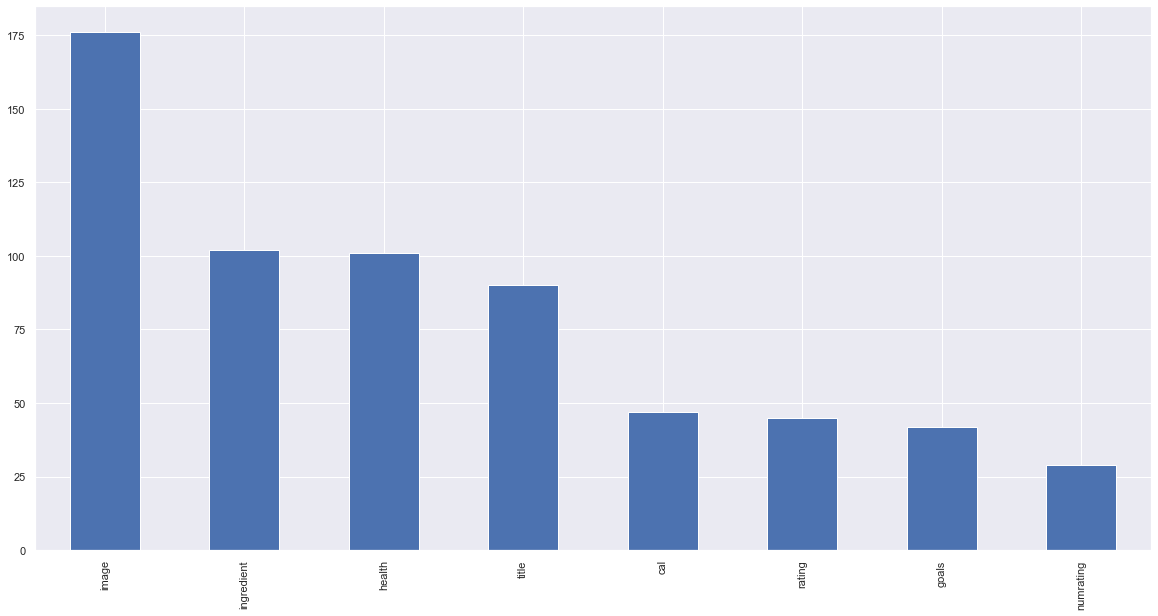

In [258]:
# Nutriscore
print(e1['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8).plot.bar())
#print(e1['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8))

AxesSubplot(0.125,0.125;0.775x0.755)


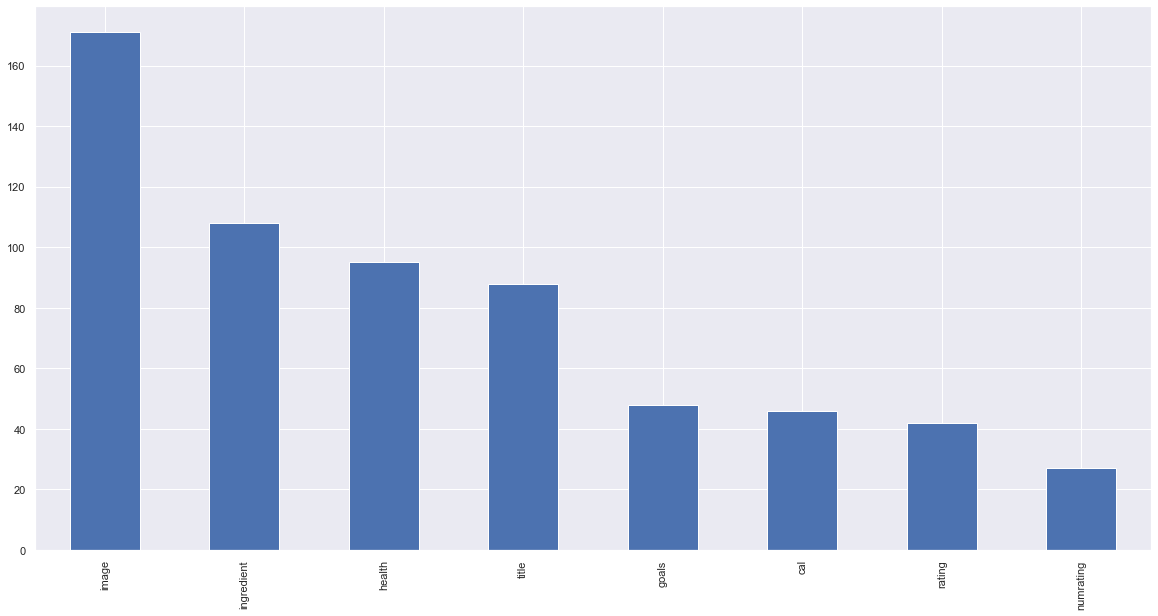

In [257]:
# MTL
print(e2['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8).plot.bar())
#print(e2['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8))

AxesSubplot(0.125,0.125;0.775x0.755)


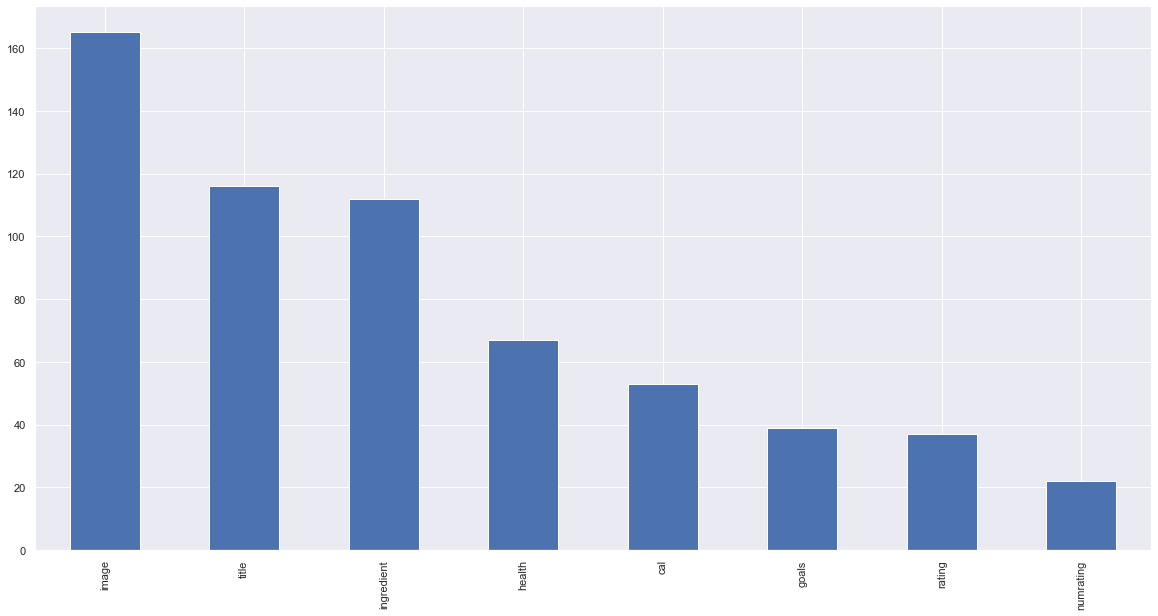

In [256]:
# No-label
print(e3['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8).plot.bar())
#print(e3['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8))

In [264]:
print("Nutriscore\n", e1['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8))
print("MTL\n", e2['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8))
print("No-label\n", e3['label_q3'].str.split(",",expand=True).stack().value_counts().nlargest(8))

Nutriscore
 image         176
ingredient    102
health        101
title          90
cal            47
rating         45
goals          42
numrating      29
dtype: int64
MTL
 image         171
ingredient    108
health         95
title          88
goals          48
cal            46
rating         42
numrating      27
dtype: int64
No-label
 image         165
title         116
ingredient    112
health         67
cal            53
goals          39
rating         37
numrating      22
dtype: int64


* 

# PERSONAL FACTORS

## Cooking experience 

### One-way ANOVA to check if cooking experience affected the FSA score for different variant within the different conditions. 

In [451]:
# One-way ANOVA
f_oneway(low_cooking['fsa_score'], medium_cooking['fsa_score'],high_cooking['fsa_score'])

F_onewayResult(statistic=0.06772606231353655, pvalue=0.9345185205253687)

In [12]:
import scipy.stats as stats

stats.f_oneway(low_cooking['fsa_score'], medium_cooking['fsa_score'],high_cooking['fsa_score'])

F_onewayResult(statistic=0.06772606231353655, pvalue=0.9345185205253687)

####  Condition 1: Variants

In [452]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 1)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 1)],high_cooking['fsa_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 1)])

F_onewayResult(statistic=0.9462263497986607, pvalue=0.3897356355065783)

In [453]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 2)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 2)],high_cooking['fsa_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 2)])

F_onewayResult(statistic=0.6708575517867373, pvalue=0.5122850721262476)

In [454]:
# One-way ANOVA Compare variant 3: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 1)&(low_cooking['variant'] == 3)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 1)&(medium_cooking['variant'] == 3)],high_cooking['fsa_score'][(high_cooking['condition'] == 1)&(high_cooking['variant'] == 3)])

F_onewayResult(statistic=0.5911703781902876, pvalue=0.5545327741817698)

* No statistical differences between participants with Low, Medium or High cooking experience with Nutriscore

####  Condition 2: Variants

In [455]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 1)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 1)],high_cooking['fsa_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 1)])

F_onewayResult(statistic=2.63051479442231, pvalue=0.07423683013874392)

In [456]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 2)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 2)],high_cooking['fsa_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 2)])

F_onewayResult(statistic=2.032366652337374, pvalue=0.1334024346116056)

In [457]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 2)&(low_cooking['variant'] == 3)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 2)&(medium_cooking['variant'] == 3)],high_cooking['fsa_score'][(high_cooking['condition'] == 2)&(high_cooking['variant'] == 3)])

F_onewayResult(statistic=2.4669448672608505, pvalue=0.08711577016921662)

* 

#### Condition 3: Variant

In [458]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 3)&(low_cooking['variant'] == 1)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 3)&(medium_cooking['variant'] == 1)],high_cooking['fsa_score'][(high_cooking['condition'] == 3)&(high_cooking['variant'] == 1)])

F_onewayResult(statistic=0.049318968757184785, pvalue=0.9518877494125018)

In [459]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 3)&(low_cooking['variant'] == 2)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 3)&(medium_cooking['variant'] == 2)],high_cooking['fsa_score'][(high_cooking['condition'] == 3)&(high_cooking['variant'] == 2)])

F_onewayResult(statistic=1.4496413411878597, pvalue=0.2368375099923825)

In [460]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_cooking['fsa_score'][(low_cooking['condition'] == 3)&(low_cooking['variant'] == 3)], medium_cooking['fsa_score'][(medium_cooking['condition'] == 3)&(medium_cooking['variant'] == 3)],high_cooking['fsa_score'][(high_cooking['condition'] == 3)&(high_cooking['variant'] == 3)])

F_onewayResult(statistic=0.050944845228358654, pvalue=0.9503420432144184)

* No statistical differences between participants with Low, Medium or High cooking experience with No-label

## Education
low_edu
bach_edu
high_edu 

### One-way ANOVA to check if cooking experience affected the FSA score for different variant within the different conditions. 

In [278]:
# One-way ANOVA
f_oneway(low_edu['fsa_score'], bach_edu['fsa_score'],high_edu['fsa_score'])

F_onewayResult(statistic=1.721711077891976, pvalue=0.1790196633389674)

####  Condition 1: Variants

In [279]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 1)], bach_edu['fsa_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 1)],high_edu['fsa_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 1)])

F_onewayResult(statistic=1.7658746690643075, pvalue=0.17339919780049312)

In [280]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 2)], bach_edu['fsa_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 2)],high_edu['fsa_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 2)])

F_onewayResult(statistic=1.1958872114531065, pvalue=0.30435037415267435)

In [281]:
# One-way ANOVA Compare variant 3: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 1)&(low_edu['variant'] == 3)], bach_edu['fsa_score'][(bach_edu['condition'] == 1)&(bach_edu['variant'] == 3)],high_edu['fsa_score'][(high_edu['condition'] == 1)&(high_edu['variant'] == 3)])

F_onewayResult(statistic=2.0798954375653764, pvalue=0.1273389740806354)

* No statistical differences between participants with Low, Medium or High cooking experience with Nutriscore

####  Condition 2: Variants

In [282]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 1)], bach_edu['fsa_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 1)],high_edu['fsa_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 1)])

F_onewayResult(statistic=2.1053760059945823, pvalue=0.12418250756811688)

In [283]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 2)], bach_edu['fsa_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 2)],high_edu['fsa_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 2)])

F_onewayResult(statistic=0.009983728938211237, pvalue=0.9900663796744424)

In [284]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 2)&(low_edu['variant'] == 3)], bach_edu['fsa_score'][(bach_edu['condition'] == 2)&(bach_edu['variant'] == 3)],high_edu['fsa_score'][(high_edu['condition'] == 2)&(high_edu['variant'] == 3)])

F_onewayResult(statistic=0.7023071445694904, pvalue=0.4965189206141365)

* No SS

#### Condition 3: Variant

In [285]:
# One-way ANOVA Compare variant 1: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 3)&(low_edu['variant'] == 1)], bach_edu['fsa_score'][(bach_edu['condition'] == 3)&(bach_edu['variant'] == 1)],high_edu['fsa_score'][(high_edu['condition'] == 3)&(high_edu['variant'] == 1)])

F_onewayResult(statistic=0.7019444640454016, pvalue=0.49672221548601714)

In [286]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 3)&(low_edu['variant'] == 2)], bach_edu['fsa_score'][(bach_edu['condition'] == 3)&(bach_edu['variant'] == 2)],high_edu['fsa_score'][(high_edu['condition'] == 3)&(high_edu['variant'] == 2)])

F_onewayResult(statistic=0.7832129833859697, pvalue=0.4581996091125138)

In [287]:
# One-way ANOVA Compare variant 2: fsa -- cooking experience
f_oneway(low_edu['fsa_score'][(low_edu['condition'] == 3)&(low_edu['variant'] == 3)], bach_edu['fsa_score'][(bach_edu['condition'] == 3)&(bach_edu['variant'] == 3)],high_edu['fsa_score'][(high_edu['condition'] == 3)&(high_edu['variant'] == 3)])

F_onewayResult(statistic=2.5031794693417324, pvalue=0.08414212166598463)

* No statistical differences between participants with Low, Medium or High education with No-label

## Goals
* Would expect people with lose weight, or eat healthier to ...

* Put participants with different goals into groups: 
    * more (participants who want to eat more protein, fruit, vegetables or gain weight)
    * no_goal
    * reduce (participants who want to reduce their intake of food/nutrient, in this case lose weight/ eat less salt)

In [461]:
more = ms[ms['user_id'].isin(more)]
no_goal = ms[ms['user_id'].isin(no_goal)]
reduce = ms[ms['user_id'].isin(reduce)]

### One-way ANOVA to check if goals affected the FSA score for different variant within the different conditions. 

In [462]:
# One-way ANOVA
f_oneway(more['fsa_score'], no_goal['fsa_score'],reduce['fsa_score'])

F_onewayResult(statistic=nan, pvalue=nan)

####  Condition 1: Variants

In [349]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 1)&(more['variant'] == 1)], no_goal['fsa_score'][(no_goal['condition'] == 1)&(no_goal['variant'] == 1)],reduce['fsa_score'][(reduce['condition'] == 1)&(reduce['variant'] == 1)])

F_onewayResult(statistic=1.4098290755117537, pvalue=0.2479217545845923)

In [350]:
# One-way ANOVA Compare variant 2: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 1)&(more['variant'] == 2)], no_goal['fsa_score'][(no_goal['condition'] == 1)&(no_goal['variant'] == 2)],reduce['fsa_score'][(reduce['condition'] == 1)&(reduce['variant'] == 2)])

F_onewayResult(statistic=0.5315169654412201, pvalue=0.5889942129371795)

In [351]:
# One-way ANOVA Compare variant 3: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 1)&(more['variant'] == 3)], no_goal['fsa_score'][(no_goal['condition'] == 1)&(no_goal['variant'] == 3)],reduce['fsa_score'][(reduce['condition'] == 1)&(reduce['variant'] == 3)])

F_onewayResult(statistic=2.351636798045147, pvalue=0.09928295408477635)

* No statistical differences between participants with Low, Medium or High goal with Nutriscore

####  Condition 2: Variants

In [352]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 1)], no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 1)],reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 1)])

F_onewayResult(statistic=3.198687583198422, pvalue=0.04375266613207514)

In [353]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 2)], no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 2)],reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 2)])

F_onewayResult(statistic=0.05806613902557674, pvalue=0.9436097736921513)

In [354]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 3)], no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 3)],reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 3)])

F_onewayResult(statistic=0.5189637442835437, pvalue=0.596253463430595)

In [360]:
m = more['fsa_score'][(more['condition'] == 2)&(more['variant'] == 1)]
n = no_goal['fsa_score'][(no_goal['condition'] == 2)&(no_goal['variant'] == 1)]
r = reduce['fsa_score'][(reduce['condition'] == 2)&(reduce['variant'] == 1)]
print(m.mean())
print(n.mean())
print(r.mean())

5.870967741935484
6.571428571428571
6.271186440677966


* Significant statistical difference in Condition 2 MTL Variant 1 Popular ranking (pvalue=0.04375266613207514). 
* The differene is largest between More goals (participants who want to eat more protein, fruit, vegetables or gain weight) and no goal. 

#### Condition 3: Variant

In [355]:
# One-way ANOVA Compare variant 1: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 3)&(more['variant'] == 1)], no_goal['fsa_score'][(no_goal['condition'] == 3)&(no_goal['variant'] == 1)],reduce['fsa_score'][(reduce['condition'] == 3)&(reduce['variant'] == 1)])

F_onewayResult(statistic=0.40746597064660434, pvalue=0.6661094983939156)

In [356]:
# One-way ANOVA Compare variant 2: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 3)&(more['variant'] == 2)], no_goal['fsa_score'][(no_goal['condition'] == 3)&(no_goal['variant'] == 2)],reduce['fsa_score'][(reduce['condition'] == 3)&(reduce['variant'] == 2)])

F_onewayResult(statistic=1.9873598531267693, pvalue=0.14085079425758637)

In [357]:
# One-way ANOVA Compare variant 2: fsa -- goal
f_oneway(more['fsa_score'][(more['condition'] == 3)&(more['variant'] == 3)], no_goal['fsa_score'][(no_goal['condition'] == 3)&(no_goal['variant'] == 3)],reduce['fsa_score'][(reduce['condition'] == 3)&(reduce['variant'] == 3)])

F_onewayResult(statistic=0.46401638057510175, pvalue=0.6297032019292872)

* No statistical differences between participants with Low, Medium or High education with No-label

# Americans vs. Europeans
* Biggest difference is for the MTL label (condition 2) (pvalue=0.07061497660278497), however not statistically significant difference. Europeans choose slightly healthier recipes overall. 
* mean FSA Americans MTL 6.44213649851632
* mean FSA Europeans MTL 6.246527777777778

# Discarded

In [389]:
#perform two-way ANOVA statsmodel

# Condition = Label
# Variant = Ranking
model = ols('fsa_score ~ C(Label) + C(Rank) + C(Label):C(Rank)', data=anova_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
aov_table



,sum_sq,df,F,PR(>F),eta_sq,omega_sq
C(Label),30.719553,2.0,8.250129,0.000270,0.007881,0.006923
C(Rank),5.844380,2.0,1.569583,0.208379,0.001499,0.000544
C(Label):C(Rank),1.880961,4.0,0.252578,0.908192,0.000483,-0.001427
Residual,3859.432627,2073.0,NaN,NaN,NaN,NaN


## Two-way ANOVA
To examine RQ1, a two-way repeated measures ANOVA was conducted to compare the influence of labels and ranking on the healthiness of recipes chosen across three different trials.
* No-label and Random ranking as baseline


In [321]:
#perform two-way ANOVA

# Condition = Label
# Variant = Ranking
model = ols('fsa_score ~ C(Label, Treatment(reference="No-label")) + C(Rank, Treatment(reference="Random")) + C(Label):C(Rank)', data=anova_df).fit()
aov_table = sm.stats.anova_lm(model, typ=2)
eta_squared(aov_table)
omega_squared(aov_table)
aov_table

print(model.summary())

,sum_sq,df,F,PR(>F),eta_sq,omega_sq
"C(Label, Treatment(reference=""No-label""))",647.691855,2.0,173.945933,1.461113e-70,0.032981,0.032788
"C(Rank, Treatment(reference=""Random""))",2771.896045,2.0,744.428140,2.200881e-244,0.141147,0.140944
C(Label):C(Rank),12359.390176,8.0,829.818082,0.000000e+00,0.629348,0.628530
Residual,3859.432627,2073.0,NaN,NaN,NaN,NaN


In [74]:
print(model.summary())

# Alain: Is it correct to set No-label and Random as baseline for this model? 

                            OLS Regression Results                            
Dep. Variable:              fsa_score   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     2.581
Date:                Wed, 28 Apr 2021   Prob (F-statistic):            0.00836
Time:                        11:08:31   Log-Likelihood:                -3596.7
No. Observations:                2082   AIC:                             7211.
Df Residuals:                    2073   BIC:                             7262.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                              coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------

In [16]:
# estimate the p-values
model.pvalues

Intercept                                                   0.000000e+00
C(Label, Treatment(reference="No-label"))[T.MTL]            5.244134e-36
C(Label, Treatment(reference="No-label"))[T.Nutriscore]     1.957808e-45
C(Rank, Treatment(reference="Random"))[T.Health]           2.405369e-121
C(Rank, Treatment(reference="Random"))[T.Popular]           2.721303e-74
C(Rank)[T.Popular]                                          2.721303e-74
C(Rank)[T.Random]                                          3.480910e-105
C(Label)[T.No-label]:C(Rank)[Health]                        2.557556e-19
C(Label)[T.Nutriscore]:C(Rank)[Health]                      1.334047e-01
C(Label)[T.No-label]:C(Rank)[Popular]                       4.147792e-19
C(Label)[T.Nutriscore]:C(Rank)[Popular]                     1.029329e-01
C(Label)[T.No-label]:C(Rank)[Random]                        6.369317e-18
C(Label)[T.Nutriscore]:C(Rank)[Random]                      1.301306e-02
dtype: float64

In [ ]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
tukey = pairwise_tukeyhsd(endog=df['score'],
                          groups=df['group'],
                          alpha=0.05)